In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


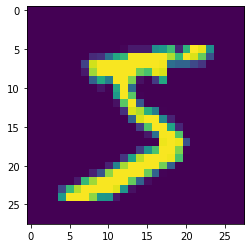

In [4]:
plt.imshow(X_train[0])

In [5]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

## Filtering out the Data for Faster Training on Smaller Dataset

In [6]:
only_zeros = X_train[y_train==0]

In [7]:
only_zeros.shape

(5923, 28, 28)

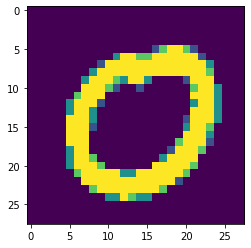

In [8]:
plt.imshow(only_zeros[950])

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Reshape,Flatten
from tensorflow.keras.models import Sequential

In [10]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 100

In [11]:
generator = Sequential()
generator.add(Dense(100, activation="relu", input_shape=[codings_size]))
generator.add(Dense(150,activation='relu'))
generator.add(Dense(784, activation="sigmoid")) # 28*28 = 784
generator.add(Reshape([28,28]))

In [12]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=[28,28]))
discriminator.add(Dense(150,activation='relu'))
discriminator.add(Dense(100,activation='relu'))
discriminator.add(Dense(1,activation="sigmoid"))

discriminator.compile(loss="binary_crossentropy", optimizer="adam")

In [13]:
GAN = Sequential([generator, discriminator])

In [14]:
discriminator.trainable = False

In [15]:
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [16]:
GAN.layers

In [17]:
GAN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28)            143634    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 132951    
Total params: 276,585
Trainable params: 143,634
Non-trainable params: 132,951
_________________________________________________________________


In [18]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 150)               15150     
_________________________________________________________________
dense_2 (Dense)              (None, 784)               118384    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 143,634
Trainable params: 143,634
Non-trainable params: 0
_________________________________________________________________


In [19]:
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 150)               117750    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 265,902
Trainable params: 132,951
Non-trainable params: 132,951
_________________________________________________________________


### Setting up Training Batches

In [20]:
import tensorflow as tf

In [21]:
batch_size = 32

https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

The buffer_size in Dataset.shuffle() can affect the randomness of your dataset, and hence the order in which elements are produced. 

In [22]:
# my_data = X_train
my_data = only_zeros

In [23]:
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [24]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [25]:
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [26]:
epochs = 1

**NOTE: The generator never actually sees any real images. It learns by viewing the gradients going back through the discriminator. The better the discrimnator gets through training, the more information the discriminator contains in its gradients, which means the generator can being to make progress in learning how to generate fake images, in our case, fake zeros.**

## Training Loop

In [27]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0
    # For every batch in the dataset
    for X_batch in dataset:
        i=i+1
        if i%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")
        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################
        
        # Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # Generate numbers based just on noise input
        gen_images = generator(noise)
        
        # Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(X_batch,tf.float32)], axis=0)
        
        # Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
        
        # This gets rid of a Keras warning
        discriminator.trainable = True
        
        # Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################
        
        # Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.]] * batch_size)
        
        # Avois a warning
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            

Currently on Epoch 1
	Currently on batch number 100 of 185
TRAINING COMPLETE


In [28]:
# Most likely your generator will only learn to create one type of noisey zero
# Regardless of what noise is passed in.

https://www.quora.com/What-does-it-mean-if-all-produced-images-of-a-GAN-look-the-same

In [28]:
noise = tf.random.normal(shape=[10, codings_size])

In [29]:
noise.shape

TensorShape([10, 100])

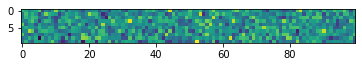

In [30]:
plt.imshow(noise)

In [31]:
image = generator(noise)

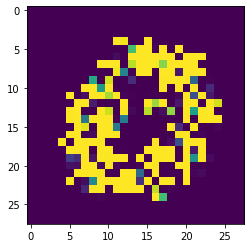

In [32]:
plt.imshow(image[5])

** At this point we need very powerful GPUs to achieve realistic results!**